## Uso de las vecotores con algoritmo de KNN 

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread
import json
import matplotlib.pyplot as plt
from rtree import index
import numpy as np

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import funcs 

output_dir = "features15k"
descriptors, mapping = funcs.load_features(output_dir)


In [2]:
print("Descriptores cargados:")
print(f"- Total descriptores: {descriptors.shape[0]}")
print(f"- Dimensiones descriptores: {descriptors.shape[1]}")
print(f"- Mapeo de imágenes: {len(mapping)}")


Descriptores cargados:
- Total descriptores: 15019
- Dimensiones descriptores: 44
- Mapeo de imágenes: 15019


## Uso de KNN

In [3]:
def create_rtree_index(descriptors):
    p = index.Property()
    p.dimension = 44  # Dimensión de los embeddings faciales
    idx = index.Index(properties=p)
    
    for i, descriptor in enumerate(descriptors):
        # Usamos cada dimensión como límite inferior y superior
        idx.insert(i, tuple(descriptor) + tuple(descriptor))
    return idx


# Búsqueda KNN usando R-Tree
def knn_rtree(query_vector, idx, descriptors, k=5):
    # Buscamos en el índice
    nearest_neighbors = list(idx.nearest(tuple(query_vector) + tuple(query_vector), k))
    # Retornamos los vecinos con sus distancias calculadas
    return [(i, funcs.euclidean_distance(query_vector, descriptors[i])) for i in nearest_neighbors]

7977
rtree.index.Index(bounds=[-27.47797203063965, -23.490861892700195, -14.958309173583984, -16.984277725219727, -12.671154975891113, -17.768659591674805, -21.889421463012695, -8.07327938079834, -9.821680068969727, -6.370837211608887, -10.001320838928223, -6.645252704620361, -7.617834091186523, -8.051076889038086, -7.3551836013793945, -8.32458209991455, -5.102726936340332, -8.041702270507812, -6.272093772888184, -6.490525722503662, -4.7167510986328125, -5.073976993560791, -4.5018792152404785, -4.704530239105225, -3.4974374771118164, -5.059284210205078, -3.945796251296997, -3.8314974308013916, -2.798854112625122, -3.2860171794891357, -5.500128269195557, -2.840285301208496, -5.325137138366699, -4.3440446853637695, -2.765371799468994, -3.0835723876953125, -2.633535861968994, -3.475189208984375, -4.194692134857178, -2.5383753776550293, -2.2176122665405273, -4.156663417816162, -2.463801145553589, -2.3966376781463623, 32.497745513916016, 19.629484176635742, 23.967565536499023, 10.7031621932

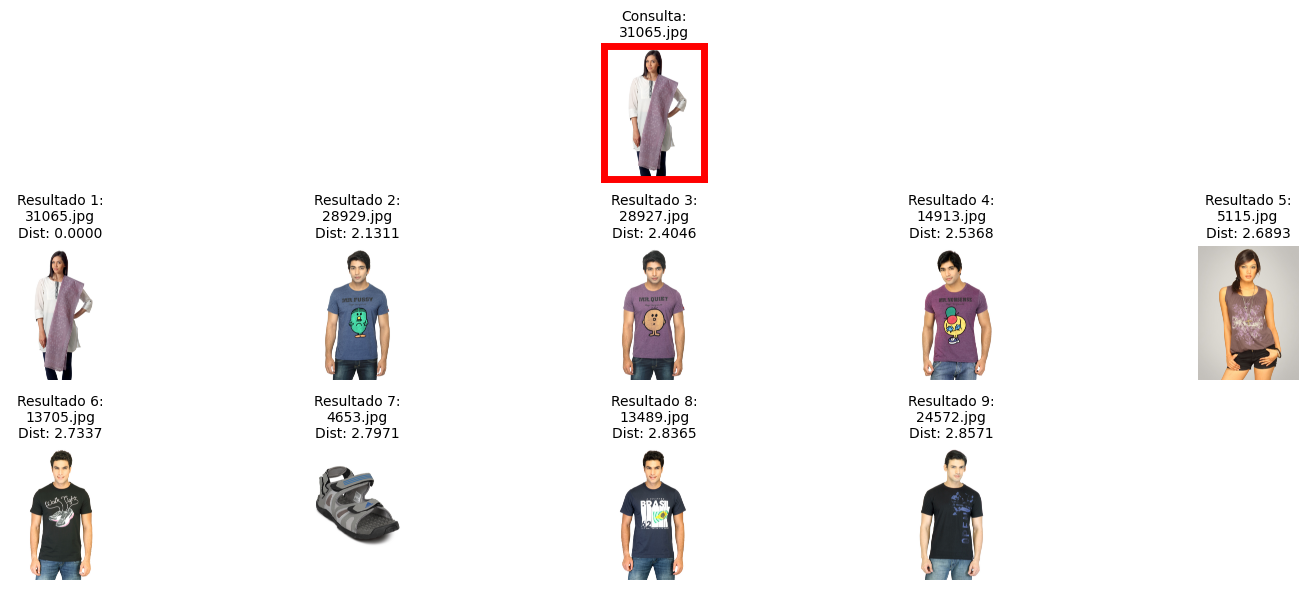

In [ ]:
# Imagen aleatoria del dataset
random = funcs.select_random_query(descriptors)

print(random)
query_vector = descriptors[random]

k = 8
idx = create_rtree_index(descriptors)
rtree_result = knn_rtree(query_vector, idx, descriptors, k=k)

print(idx)
print(rtree_result)

funcs.show_results(rtree_result, output_dir, random, k)


### NO ejecutar está parte si está provando el KNN, esta parte es para organizar los indices


In [6]:
import json
import pandas as pd

def get_image_by_index(index, checkpoint_path= output_dir + "/checkpoint.json", csv_path="images.csv"):
    """
    Obtiene el nombre y link de la imagen dado su índice
    
    Args:
        index (int): Índice del vector de características
        checkpoint_path (str): Ruta al archivo checkpoint.json
        csv_path (str): Ruta al archivo images.csv
        
    Returns:
        tuple: (nombre_imagen, link_imagen) o (None, None) si no existe
    """
    # Leer checkpoint
    with open(checkpoint_path, 'r') as f:
        checkpoint = json.load(f)
    
    # Invertir el diccionario para buscar por índice
    index_to_image = {v: k for k, v in checkpoint.items()}
    
    # Obtener nombre de imagen del índice
    image_name = index_to_image.get(index)
    if not image_name:
        return None, None
        
    # Buscar en CSV
    df = pd.read_csv(csv_path)
    image_data = df[df['filename'] == image_name]
    
    if image_data.empty:
        return None, None
        
    return image_name, image_data.iloc[0]['link']

# # Ejemplo de uso:
# nombre, link = get_image_by_index(0)
# print(f"Nombre: {nombre}")
# print(f"Link: {link}")

In [7]:
def save_image_mapping(output_path= output_dir + "/image_mapping.json", checkpoint_path= output_dir +  "/checkpoint.json", csv_path="images.csv"):
    """
    Crea un JSON con mapeo de índices, nombres y links verificados
    
    Args:
        output_path (str): Ruta donde guardar el nuevo JSON
        checkpoint_path (str): Ruta del checkpoint.json
        csv_path (str): Ruta del CSV con links
    """
    # Leer checkpoint y CSV
    with open(checkpoint_path, 'r') as f:
        checkpoint = json.load(f)
    
    df = pd.read_csv(csv_path)
    
    # Crear nuevo diccionario con la información completa
    image_mapping = {}
    
    for image_name, vector_index in checkpoint.items():
        # Buscar link en CSV
        image_data = df[df['filename'] == image_name]
        
        if not image_data.empty:
            link = image_data.iloc[0]['link']
            image_mapping[vector_index] = {
                'filename': image_name,
                'link': link
            }
        else:
            print(f"Advertencia: No se encontró link para {image_name}")
    
    # Guardar el nuevo mapping
    with open(output_path, 'w') as f:
        json.dump(image_mapping, f, indent=4)
    
    print(f"Mapping guardado en {output_path}")
    print(f"Total de imágenes mapeadas: {len(image_mapping)}")

# # Ejemplo de uso:
# save_image_mapping()